In [1]:
!pip install -q tensorflow
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 89 kB 4.0 MB/s 
     |████████████████████████████████| 4.7 MB 5.1 MB/s 


In [2]:
!unzip Netflix_Dataset_Rating.csv.zip

Archive:  Netflix_Dataset_Rating.csv.zip
  inflating: Netflix_Dataset_Rating.csv  


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
ratings = pd.read_csv("Netflix_Dataset_Rating.csv.zip", low_memory=False, compression='zip')

ratings.sample(10)

,User_ID,Rating,Movie_ID
4809293,2061426,2,1307
11613568,422864,4,3128
1026818,1085676,4,299
5379156,1539389,5,1495
7600105,1054137,3,2043
8933151,889233,3,2386
2927658,532929,4,759
11315021,306736,3,3054
9084709,1268171,3,2405
13951815,389289,3,3650


In [5]:
ratings["User_ID"] = ratings["User_ID"].astype(str)
ratings["Movie_ID"] = ratings["Movie_ID"].astype(str)

In [6]:
users_idx = ratings["User_ID"].unique()
movies_idx = ratings["Movie_ID"].unique()

In [7]:
print("Number of users in rating table: ", len(users_idx))
print("Number of movies in rating table: ", len(movies_idx))

Number of users in rating table:  143458
Number of movies in rating table:  1350


In [8]:
print("Number of rating lines in the database", len(ratings))

Number of rating lines in the database 17337458


In [9]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

import warnings

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

warnings.filterwarnings("ignore")
plt.style.use('seaborn-whitegrid')

In [10]:
rating_mean = ratings.Rating.mean()
rating_mean

3.590569909383486

In [11]:
movies_ratings_mean = ratings.groupby("Movie_ID")["Rating"].mean()

movies_ratings_mean.sample(5)

Movie_ID
1134    3.503420
4086    3.307788
3715    3.357383
3610    3.728515
996     4.021298
Name: Rating, dtype: float64

In [12]:
movies_ratings_mean.describe()

count    1350.000000
mean        3.485986
std         0.422594
min         1.962031
25%         3.210124
50%         3.508991
75%         3.767958
max         4.665432
Name: Rating, dtype: float64

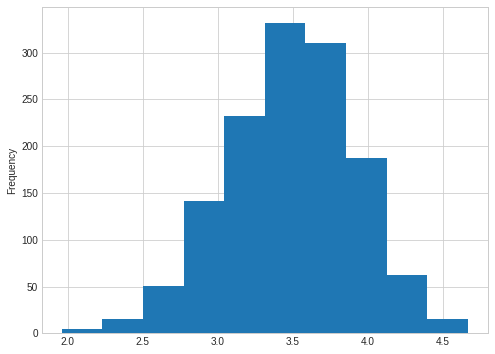

In [13]:
movies_ratings_mean.plot.hist()

In [14]:
users_ratings_mean = ratings.groupby("User_ID")["Rating"].mean()

users_ratings_mean.sample(5)

User_ID
2502775    3.878788
1584274    3.658120
2514107    3.236264
1633863    3.217617
258319     3.329545
Name: Rating, dtype: float64

In [15]:
users_ratings_mean.describe()

count    143458.000000
mean          3.636473
std           0.414033
min           1.000000
25%           3.367521
50%           3.631579
75%           3.903846
max           5.000000
Name: Rating, dtype: float64

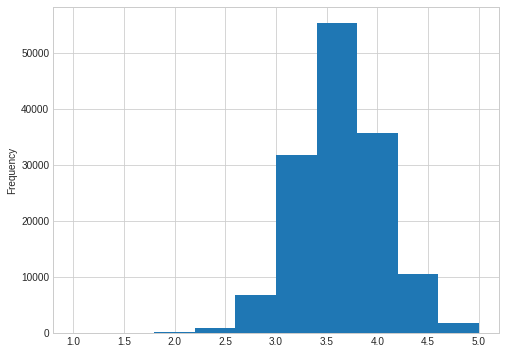

In [16]:
users_ratings_mean.plot.hist()

Normalize per movies rating of users
```
def normalize_per_movie(data):
    data["Rating"] = data["Rating"]-data["Rating"].mean()
    return data

ratings = ratings.groupby("Movie_ID").apply(normalize_per_movie)
```

In [17]:
ratings.head()

,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3


In [18]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337458 entries, 0 to 17337457
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   User_ID   object
 1   Rating    int64 
 2   Movie_ID  object
dtypes: int64(1), object(2)
memory usage: 396.8+ MB


Split data into training and testing dataset regarding the User_ID

In [19]:
train = ratings.groupby("User_ID").sample(frac=0.8)
test = ratings.drop(index=train.index)

In [20]:
train.head()

,User_ID,Rating,Movie_ID
4563085,1000033,3,1220
8300225,1000033,3,2186
9510470,1000033,2,2493
9165386,1000033,5,2441
14668720,1000033,3,3860


In [21]:
train.shape, test.shape

((13870063, 3), (3467395, 3))

## TensorFlow Recommenders

TensorFlow Recommenders (TFRS) is a library for building recommender system models.

It helps with the full workflow of building a recommender system: data preparation, model formulation, training, evaluation, and deployment.

It's built on Keras and aims to have a gentle learning curve while still giving you the flexibility to build complex models.

TFRS makes it possible to:* Build and evaluate flexible recommendation retrieval models.

* Freely incorporate item, user, and [context information](https://www.tensorflow.org/recommenders/examples/featurization) into recommendation models.
* Train [multi-task models](https://www.tensorflow.org/recommenders/examples/multitask/) that jointly optimize multiple recommendation objectives.


In [22]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

Create Custom TensorDataset

In [23]:
train_ratings = tf.data.Dataset.from_tensor_slices(
    {
        "movie_id": train.Movie_ID.values,
        "user_id": train.User_ID.values,
        "rating": train.Rating.astype(np.float32).values
    }
)

test_ratings = tf.data.Dataset.from_tensor_slices(
    {
        "movie_id": test.Movie_ID.values,
        "user_id": test.User_ID.values,
        "rating": test.Rating.astype(np.float32).values
    }
)

### Build Ranking Model

Our `Ranking Model` is consists of three simples neurals networks :
- User embedding network `u`: which map User_ID to an embedding space 32
- Model embedding network `m`: which map Movie_ID to an embedding space 32
- Ranking Model: tries to estimate the ranking of User_ID on Movie_ID. Formally, we try to minimize this loss function :
$L(u_{id}, m_{id}) = || dot(u(u_{id}), m(u_{id})) - r || + Reg(u(u_{id})) + Reg(m(m_{id}))$

In [24]:
class RankingModel(tf.keras.Model):

    def __init__(self, users_idx, movies_idx):
        super().__init__()
        embedding_dimension = 32

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
            vocabulary=users_idx, mask_token=None),
            tf.keras.layers.Embedding(len(users_idx) + 1, embedding_dimension)
        ])

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
            vocabulary=movies_idx, mask_token=None),
            tf.keras.layers.Embedding(len(movies_idx) + 1, embedding_dimension)
        ])

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
            # Learn multiple dense layers.
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            # Make rating predictions in the final layer.
            tf.keras.layers.Dense(1)
        ])

    def call(self, inputs):
        user_id, movie_title = inputs

        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)

        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

Consider User_ID `6` and Movie_ID `1918` then compute the ranking value with random initialized model

In [25]:
RankingModel(
    users_idx, movies_idx
)((["6"], ["1918"]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01994305]], dtype=float32)>

### Netflix Model

Took in input our ranking models and uses tfrec library to effectively build a ranking model.

In [26]:
class NetflixModel(tfrs.models.Model):

    def __init__(self, users_idx, movies_idx):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel(users_idx, movies_idx)
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model(
            (features["user_id"], features["movie_id"]))

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        labels = features.pop("rating")

        rating_predictions = self(features)

        # The task computes the loss and the metrics.
        return self.task(labels=labels, predictions=rating_predictions)

Compile then fit our NetflixModel with Adagrad Optimizer

In [38]:
model = NetflixModel(users_idx, movies_idx)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [28]:
cached_train = train_ratings.shuffle(100_000).batch(8192).cache()
cached_test = test_ratings.batch(4096).cache()

In [39]:
model.fit(cached_train, epochs=20)

Epoch 1/20
1694/1694 [==============================] - 9s 5ms/step - root_mean_squared_error: 1.0058 - loss: 1.0116 - regularization_loss: 0.0000e+00 - total_loss: 1.0116
Epoch 2/20
1694/1694 [==============================] - 8s 5ms/step - root_mean_squared_error: 0.9561 - loss: 0.9140 - regularization_loss: 0.0000e+00 - total_loss: 0.9140
Epoch 3/20
1694/1694 [==============================] - 8s 5ms/step - root_mean_squared_error: 0.9213 - loss: 0.8488 - regularization_loss: 0.0000e+00 - total_loss: 0.8488
Epoch 4/20
1694/1694 [==============================] - 8s 5ms/step - root_mean_squared_error: 0.9084 - loss: 0.8250 - regularization_loss: 0.0000e+00 - total_loss: 0.8250
Epoch 5/20
1694/1694 [==============================] - 8s 5ms/step - root_mean_squared_error: 0.9039 - loss: 0.8169 - regularization_loss: 0.0000e+00 - total_loss: 0.8169
Epoch 6/20
1694/1694 [==============================] - 8s 5ms/step - root_mean_squared_error: 0.9020 - loss: 0.8135 - regularization_loss: 

In [40]:
model.evaluate(cached_test, return_dict=True)

847/847 [==============================] - 3s 3ms/step - root_mean_squared_error: 0.8771 - loss: 0.7695 - regularization_loss: 0.0000e+00 - total_loss: 0.7695


{'root_mean_squared_error': 0.8770737051963806,
 'loss': 0.903956949710846,
 'regularization_loss': 0,
 'total_loss': 0.903956949710846}

In [31]:
test.head()

,User_ID,Rating,Movie_ID
1,1331154,4,3
18,948069,3,3
29,79160,4,3
46,2213550,4,3
48,2344483,4,3


## Select User and Make a prediction

`User_ID` : 712664

In [32]:
user_id = "712664"
sample_test = test[test.User_ID==user_id].head(10)
sample_test

,User_ID,Rating,Movie_ID
27004,712664,3,26
198826,712664,1,77
411093,712664,5,175
799580,712664,5,256
1668999,712664,5,442
2021002,712664,4,499
2096543,712664,4,534
2159887,712664,5,561
2305550,712664,3,599
2639583,712664,4,705


In [41]:
test_ratings = {}
for movie_id in sample_test.Movie_ID.values:
    test_ratings[movie_id] = model({
        "user_id": np.array([user_id]),
        "movie_id": np.array([str(movie_id)])
    })

In [42]:
print("Ratings:")
for movie_id, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
    print(f"{movie_id}: {score}")

Ratings:
175: [[4.546181]]
561: [[4.523028]]
442: [[4.2044053]]
256: [[4.062814]]
534: [[3.9008904]]
599: [[3.5699692]]
705: [[3.399195]]
499: [[3.318517]]
26: [[2.6186924]]
77: [[1.7673537]]


In [43]:
sample_test

,User_ID,Rating,Movie_ID
27004,712664,3,26
198826,712664,1,77
411093,712664,5,175
799580,712664,5,256
1668999,712664,5,442
2021002,712664,4,499
2096543,712664,4,534
2159887,712664,5,561
2305550,712664,3,599
2639583,712664,4,705


In [44]:
predicted_ratinds = pd.DataFrame([(mov_id, float(r)) for mov_id, r in test_ratings.items()], columns=["Movie_ID", "Pred_Rating"])
predicted_ratinds

,Movie_ID,Pred_Rating
0,26,2.618692
1,77,1.767354
2,175,4.546181
3,256,4.062814
4,442,4.204405
5,499,3.318517
6,534,3.900890
7,561,4.523028
8,599,3.569969
9,705,3.399195


In [45]:
pd.merge(sample_test, predicted_ratinds, on="Movie_ID")[["User_ID", "Movie_ID", "Rating", "Pred_Rating"]]

,User_ID,Movie_ID,Rating,Pred_Rating
0,712664,26,3,2.618692
1,712664,77,1,1.767354
2,712664,175,5,4.546181
3,712664,256,5,4.062814
4,712664,442,5,4.204405
5,712664,499,4,3.318517
6,712664,534,4,3.900890
7,712664,561,5,4.523028
8,712664,599,3,3.569969
9,712664,705,4,3.399195
